# transactions_hm
- `customer_hm.csv`(고객 메타데이터)를 분석용으로 바로 merge 가능한 형태로 정리한다.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

transactions = pd.read_csv("h&m_dataset/transactions_hm.csv")
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2019-11-05,3e2b60b679e62fb49516105b975560082922011dd752ec...,698328010,0.016932,2
1,2019-05-22,89647ac2274f54c770aaa4b326e0eea09610c252381f37...,760597002,0.033881,2
2,2019-05-10,2ebe392150feb60ca89caa8eff6c08b7ef1138cd6fdc71...,488561032,0.016932,2
3,2019-08-26,7b3205de4ca17a339624eb5e3086698e9984eba6b47c56...,682771001,0.033881,2
4,2019-08-10,3b77905de8b32045f08cedb79200cdfa477e9562429a39...,742400033,0.003220,1


In [2]:
# 테이블의 전체적인 정보 확인
transactions.info()

<class 'pandas.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   t_dat             1048575 non-null  str    
 1   customer_id       1048575 non-null  str    
 2   article_id        1048575 non-null  int64  
 3   price             1048575 non-null  float64
 4   sales_channel_id  1048575 non-null  int64  
dtypes: float64(1), int64(2), str(2)
memory usage: 40.0 MB


In [3]:
# 행/열 크기 확인
transactions.shape

(1048575, 5)

In [4]:
# 결측치가 많은 컬럼 상위 확인
na_t = transactions.isna().sum().sort_values(ascending=False) 
na_t.head(3)

t_dat          0
customer_id    0
article_id     0
dtype: int64

In [5]:
transactions["sales_channel_id"].value_counts(dropna=False)

sales_channel_id
2    729192
1    319383
Name: count, dtype: int64

In [6]:
transactions.describe().round(3)

,article_id,price,sales_channel_id
count,1.048575e+06,1048575.000,1048575.000
mean,6.746672e+08,0.028,1.695
std,1.173503e+08,0.019,0.460
min,1.087750e+08,0.000,1.000
25%,6.289790e+08,0.015,1.000
50%,7.059880e+08,0.025,2.000
75%,7.500700e+08,0.034,2.000
max,8.797400e+08,0.507,2.000


# 전처리 작업
- 한 행이 한 번의 구매 기록
- customer_id                   # 구매한 고객 → customers_hm과 연결
- article_id                    # 구매한 상품 → articles_hm과 연결
- t_dat                         # 구매날짜
- price                         # 구매 가격 == 매출
- sales_channel_id              # 판매 채널 구분 (1=오프라인, 2=온라인)

### 결측치 여부
- 존재하지 않음

### 형변환
- t_dat는 문자열로 들어와있기 때문에 datetime변환이 필수
- 월별, 요일별 파생 시도 가능

### 이상치 여부
- 모든 price값이 소수점.
    - 통화 단위가 SEK 인것으로 확인
    - 데이터 출처가 기업의 판매율 데이터이기에 정규화 된것으로 추측.
    
### price
매출 금액은 SEK 기준 거래 단가 합으로, 절대 금액보다는 고객 간 상대적 비교에 초점을 둔다.

In [7]:
trans = transactions.copy()

## 날짜 컬럼 재정의

In [8]:
trans["t_dat"] = pd.to_datetime(
    trans["t_dat"],
    errors="coerce"
)
print("변환 완료 확인")
print(trans["t_dat"].dtype)

print("\n형 변환 실패 확인")
print(trans["t_dat"].isna().sum())

변환 완료 확인
datetime64[us]

형 변환 실패 확인
0


In [9]:
# 월 파생
trans["month"] = (
    trans["t_dat"]
    .dt
    .month)

# 년월 파생
trans["year_month"] = (
    trans["t_dat"]
    .dt
    .to_period("M")
    .astype(str))

# 월일 파생
trans["month_day"] = (
    trans["t_dat"]
    .dt
    .strftime("%m-%d"))

# -------------------------------------------------------------------------
# 요일 파생 큰 의미가 없을 가능성이 있기 때문에 배제
# trans["weekday"] = trans["t_dat"].dt.day_name()
# -------------------------------------------------------------------------

trans[[
    "month", 
    "year_month", 
    "month_day"
    ]].value_counts()

month  year_month  month_day
9      2019-09     09-28        12860
11     2019-11     11-29        10340
7      2019-07     07-24         8054
4      2019-04     04-06         7547
11     2019-11     11-28         6782
                                ...  
12     2019-12     12-03         1479
9      2019-09     09-21         1374
12     2019-12     12-26         1266
1      2019-01     01-01         1168
12     2019-12     12-25          895
Name: count, Length: 365, dtype: int64

### price 이상치 제거

In [10]:
# 현재 price 분포 요약 확인
#  25%, 50%, 75%, 90%, 95%, 99% 지점을 파악해 값이 대부분이 어디에 몰려 있는지 파악
summary = trans["price"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(summary)


count    1.048575e+06
mean     2.777915e-02
std      1.935764e-02
min      2.372880e-04
25%      1.523729e-02
50%      2.540678e-02
75%      3.388136e-02
90%      5.083051e-02
95%      6.100000e-02
99%      1.016780e-01
max      5.067797e-01
Name: price, dtype: float64


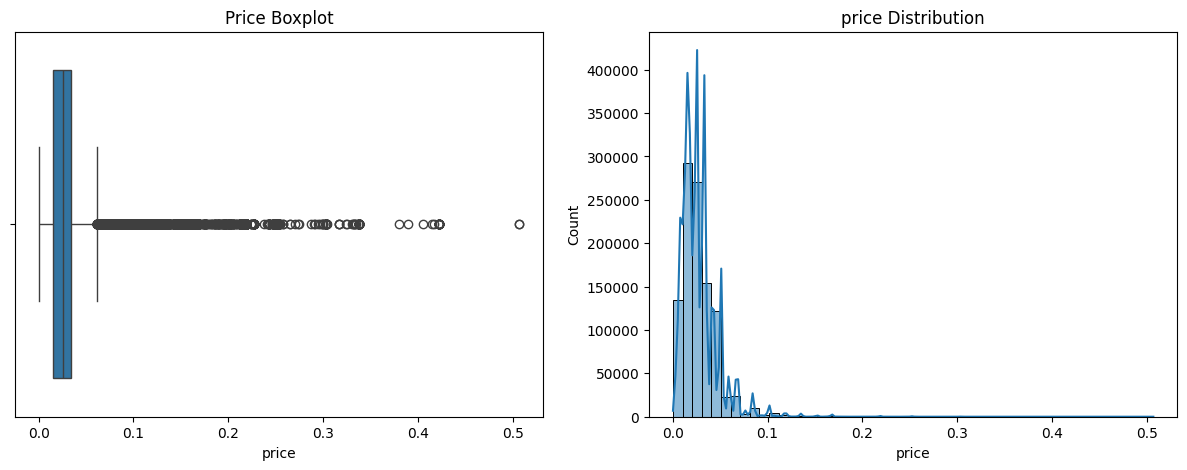

In [11]:
# 한 화면에 두 그래프 그리기
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# 왼쪽: 박스플롯 (이상치 확인)
sns.boxplot(x=trans['price'], ax=ax[0])
ax[0].set_title('Price Boxplot')

# 오른쪽: 히스토그램 (분포 모양 확인)
sns.histplot(trans['price'], bins=50, kde=True, ax=ax[1])
ax[1].set_title('price Distribution')

plt.show()

#### 해석결과
오른쪽으로 꼬리가 긴 형태 → Price Max 값은 이상치라고 간주<br>
**Price가 0 이하인 값은 이상치라고 간주**

In [12]:
# - lower_bound: 0 이하 제거
# - upper_bound: 0.1 이상 제거 (그래프/요약통계로 봤을 때 거의 없는 구간)
lower_bound = 0
upper_bound = 0.1

# 필터링 적용 + 전/후 변화 확인
trans_clean = trans.copy()

# (1) 0 이하 제거
trans_clean = trans_clean[trans_clean["price"] > lower_bound]
after_positive = len(trans_clean)

# (2) 0.1 이상 제거
trans_clean = trans_clean[trans_clean["price"] < upper_bound]
after_upper = len(trans_clean)

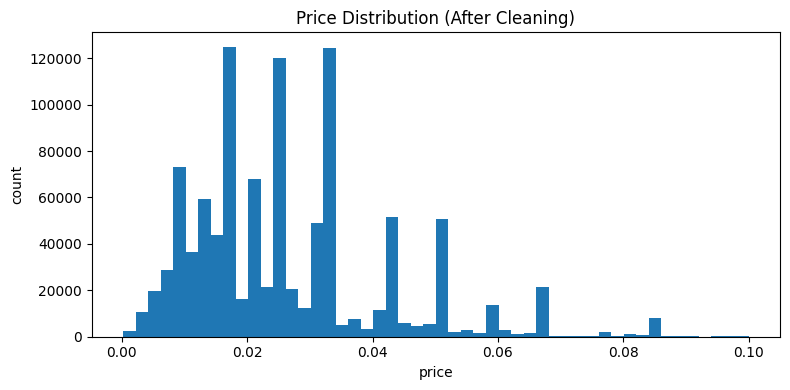

In [13]:
plt.figure(figsize=(8, 4))
plt.hist(trans_clean["price"], bins=50)
plt.title("Price Distribution (After Cleaning)")
plt.xlabel("price")
plt.ylabel("count")
plt.tight_layout()
plt.show()

### 상위 20%, 하위 20% 분류

In [14]:
# price → revenue
trans_clean = trans_clean.rename(columns={"price": "revenue"}).copy()
trans_clean["revenue"] = trans_clean["revenue"].fillna(0)



# 고객별 총 매출을 거래 테이블에 바로 붙임
trans_clean["total_revenue"] = (
    trans_clean
    .groupby("customer_id")["revenue"]
    .transform("sum")
)

# 분위수 계산 (고객 기준이므로 중복 제거 후 계산)
q20 = (
    trans_clean[["customer_id", "total_revenue"]]
    .drop_duplicates()["total_revenue"]
    .quantile(0.2)
)

q80 = (
    trans_clean[["customer_id", "total_revenue"]]
    .drop_duplicates()["total_revenue"]
    .quantile(0.8)
)

# revenue_group 컬럼 생성
## # 그룹 라벨링 (경계 포함 규칙: <=q20 / >=q80)
trans_clean["revenue_group"] = "middle"

trans_clean.loc[
    trans_clean["total_revenue"] <= q20,
    "revenue_group"
] = "bottom_20"

trans_clean.loc[
    trans_clean["total_revenue"] >= q80,
    "revenue_group"
] = "top_20"

total_revenue = trans_clean.copy()


In [15]:
print("하위 20% 분위수:", q20)
print("상위 20% 분위수:", q80)

print("전체 거래 수:", len(total_revenue))
print("전체 고객 수:", total_revenue["customer_id"].nunique())
print(
    "상위 20% 고객 수:",
    total_revenue[total_revenue["revenue_group"] == "top_20"]["customer_id"].nunique()
)
print(
    "하위 20% 고객 수:",
    total_revenue[total_revenue["revenue_group"] == "bottom_20"]["customer_id"].nunique()
)

하위 20% 분위수: 0.016932203
상위 20% 분위수: 0.085355932
전체 거래 수: 1037772
전체 고객 수: 455812
상위 20% 고객 수: 91165
하위 20% 고객 수: 92079


## 모든 컬럼명을 대상으로 첫 글자 대문자로 변경

In [16]:
total_revenue.columns = [col.title() for col in total_revenue.columns]
total_revenue.columns

Index(['T_Dat', 'Customer_Id', 'Article_Id', 'Revenue', 'Sales_Channel_Id',
       'Month', 'Year_Month', 'Month_Day', 'Total_Revenue', 'Revenue_Group'],
      dtype='str')

## 최종점검

In [17]:
total_revenue.head()

,T_Dat,Customer_Id,Article_Id,Revenue,Sales_Channel_Id,Month,Year_Month,Month_Day,Total_Revenue,Revenue_Group
0,2019-11-05,3e2b60b679e62fb49516105b975560082922011dd752ec...,698328010,0.016932,2,11,2019-11,11-05,0.227186,top_20
1,2019-05-22,89647ac2274f54c770aaa4b326e0eea09610c252381f37...,760597002,0.033881,2,5,2019-05,05-22,0.067746,middle
2,2019-05-10,2ebe392150feb60ca89caa8eff6c08b7ef1138cd6fdc71...,488561032,0.016932,2,5,2019-05,05-10,0.016932,bottom_20
3,2019-08-26,7b3205de4ca17a339624eb5e3086698e9984eba6b47c56...,682771001,0.033881,2,8,2019-08,08-26,0.033881,middle
4,2019-08-10,3b77905de8b32045f08cedb79200cdfa477e9562429a39...,742400033,0.003220,1,8,2019-08,08-10,0.028627,middle


In [18]:
total_revenue.info()

<class 'pandas.DataFrame'>
Index: 1037772 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   T_Dat             1037772 non-null  datetime64[us]
 1   Customer_Id       1037772 non-null  str           
 2   Article_Id        1037772 non-null  int64         
 3   Revenue           1037772 non-null  float64       
 4   Sales_Channel_Id  1037772 non-null  int64         
 5   Month             1037772 non-null  int32         
 6   Year_Month        1037772 non-null  str           
 7   Month_Day         1037772 non-null  str           
 8   Total_Revenue     1037772 non-null  float64       
 9   Revenue_Group     1037772 non-null  str           
dtypes: datetime64[us](1), float64(2), int32(1), int64(2), str(4)
memory usage: 83.1 MB


- T_Dat                         : 거래일
- Customer_Id                   : 고객 식별키
- Article_Id                    : 상품 식별키
- Revenue                       : 거래 1건의 구매금액
- Sales_Channel_Id              : 판매 채널 1:오프라인 2: 온라인
- Month                         : t_dat에서 뽑은 월 파생 컬럼
- Year_Month                    : t_dat를 연-월 단위로 묶은 문자열 파생 컬럼
- Total_Revenue                 : 해당 고객의 전체 구매금액 합계
- Revenue_Group                 : 해당 고객의 매출 등급(bottom_20 / middle / top_20)

In [19]:
total_revenue.shape

(1037772, 10)

In [20]:
na_t = total_revenue.isna().sum().sort_values(ascending=False) 
na_t.head(3)

T_Dat          0
Customer_Id    0
Article_Id     0
dtype: int64

In [21]:
total_revenue.to_csv("data/total_revenue.csv", index=False, encoding="utf-8-sig")